### Мы имеем датасет (стоимость страховки от параметров человека) в котором собраны данные о людях, их age, sex, bmi, children, smoker, region, charges. Изначально классов нет, поэтому сначала попробуем выделить определённые класстеры и понять чем они характерны, а после уже применять методы классификации.

1.   age - Возраст
2.   sex - Пол
3.   bmi - индекс массы тела
4.   children - кол-во детей
5.   smoker - курящий или нет
6.   region - регион
7.   charges - стоимость страховки




## Необходимые библиотеки

In [268]:
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline 
    
import pandas as pd             
import seaborn as sns           
import sklearn                  


## Загрузка датасета

In [269]:
data = pd.read_csv('insurance.csv')
data.head()
print(len(data[data['smoker'] == 'no']))

1064


Посмотрим на некоторые данные из датасета

In [270]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Проведём категоризацию признаков для которых это необходимо

In [271]:
data['sex'] = data['sex'].astype('category')
data['smoker'] = data['smoker'].astype('category')
data['region'] = data['region'].astype('category')

## Визуализируем датасет

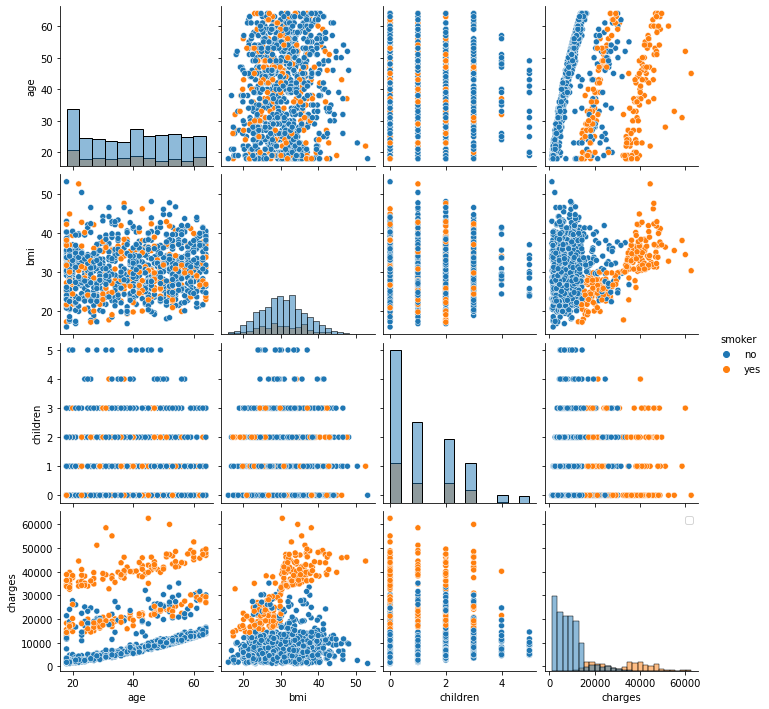

In [272]:
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
sns.pairplot(data.iloc[random_subset], hue = 'smoker', diag_kind='hist')
plt.legend()

### Вычислим основные характеристики

Построим матрицу корреляций

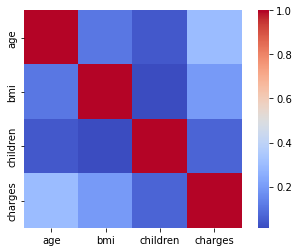

In [273]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')

In [274]:
corr_mat.where(np.triu(corr_mat > 0.4, k=1)).stack().sort_values(ascending=False)

Series([], dtype: float64)

Видно что особой корреляции между признаками нет

Посмотрим на другие основные характеристики датасета

In [275]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Предобработка перед кластеризацией

Посмотрим есть ли пропущенные занчения

In [276]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB
None


Пропущенных значений нет

Факторизуем категориальные признаки

In [277]:
data['sex'] = pd.factorize(data['sex'])[0]
data['smoker'] = pd.factorize(data['smoker'])[0]
Region_dummies = pd.get_dummies(data['region'])
data = pd.concat((data, Region_dummies), axis=1)
data = data.drop(['region'], axis=1)

data.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,0,16884.92400,0,0,0,1
1,18,1,33.770,1,1,1725.55230,0,0,1,0
2,28,1,33.000,3,1,4449.46200,0,0,1,0
3,33,1,22.705,0,1,21984.47061,0,1,0,0
4,32,1,28.880,0,1,3866.85520,0,1,0,0


Нормализуем данные

In [278]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)

### Так как у нас нет решающего признака для тренировки классификатора нам нужно его определить. Попробуем разбить наши данные на кластеры (labels)

# Разбиение на кластеры

По визуализации угадывается 3 кластера. Это подтверждается и использованием другого метода кластеризации.

In [279]:
# from sklearn.cluster import KMeans
# model = KMeans(n_clusters=3)
# model.fit(data)

Другой метод кластеризации. Удобный так как работает по плотности и не требует предварительного предположения числа кластеров.

In [280]:
from sklearn.cluster import Birch
model = Birch(threshold=0.3)
model.fit(data)

Birch(threshold=0.3)

Скопируем новый датасет чтобы не портить основной и добавем столбец с признаком принадлежнасти к определённому кластеру.

In [281]:
labels = pd.DataFrame({'labels':model.labels_})
data_new = data_stand
data_new = pd.concat((data_new, labels), axis=1)
data_new.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest,labels
0,-1.438227,-1.010141,-0.453151,-0.908274,-1.969850,0.298472,-0.565056,-0.566206,-0.611095,1.764821,2
1,-1.509401,0.989221,0.509431,-0.078738,0.507273,-0.953333,-0.565056,-0.566206,1.635183,-0.566206,0
2,-0.797655,0.989221,0.383164,1.580335,0.507273,-0.728402,-0.565056,-0.566206,1.635183,-0.566206,0
3,-0.441782,0.989221,-1.305043,-0.908274,0.507273,0.719574,-0.565056,1.764821,-0.611095,-0.566206,2
4,-0.512957,0.989221,-0.292447,-0.908274,0.507273,-0.776512,-0.565056,1.764821,-0.611095,-0.566206,0


Для визуализации и проверки уберём регионы, для удобства просмотра

In [282]:
data_new = data_new.drop(['northeast'], axis=1)
data_new = data_new.drop(['northwest'], axis=1)
data_new = data_new.drop(['southeast'], axis=1)
data_new = data_new.drop(['southwest'], axis=1)

Визуализируем полученный результат

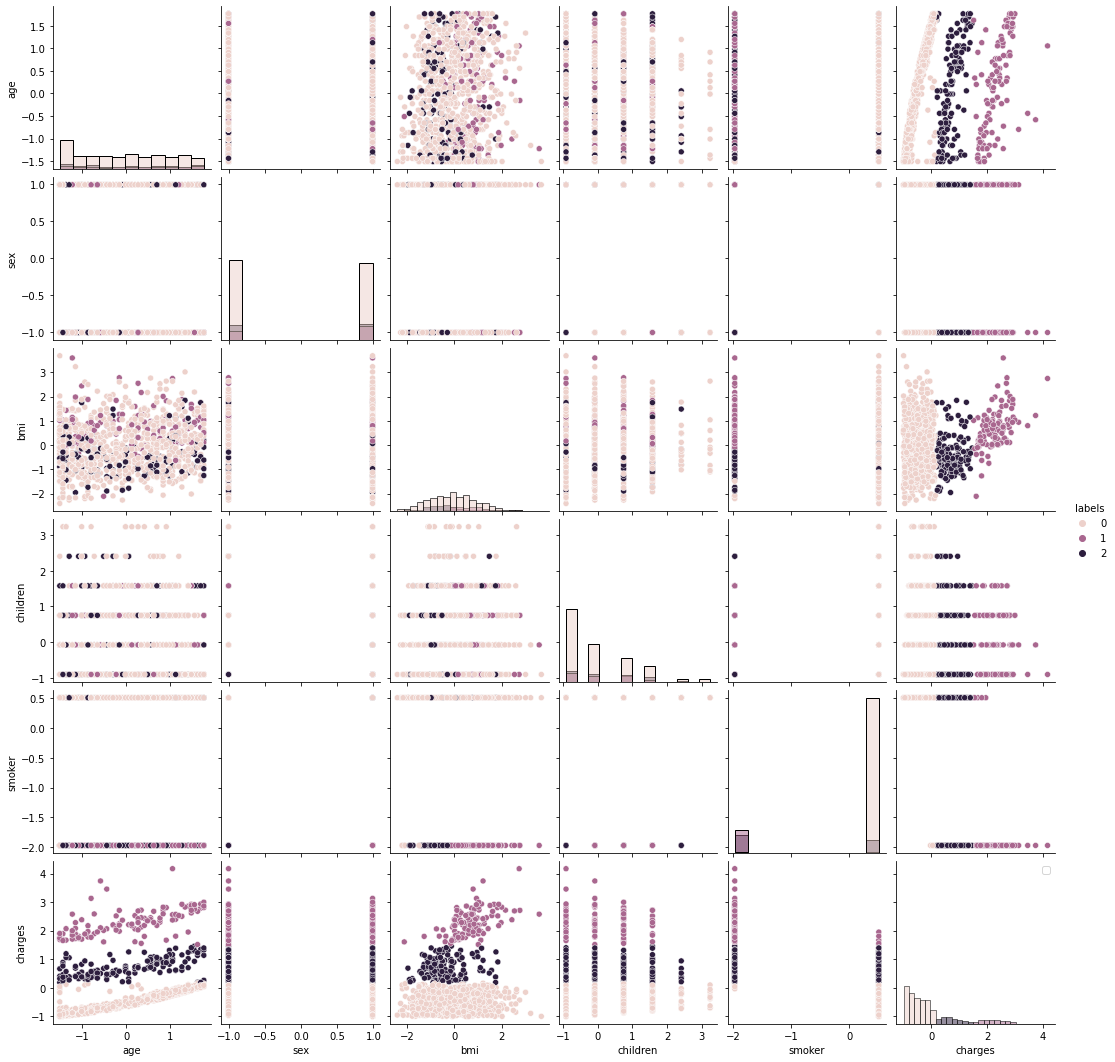

In [283]:
random_subset = np.random.choice(np.arange(data_new.shape[0]), size=1000, replace=False)
sns.pairplot(data_new.iloc[random_subset], hue = 'labels', diag_kind='hist' )
plt.legend()

Видно выделение 3 основных классов. Предположительно:
1. Не курящие с хорошим bmi
2. Курящие с нормальным bmi или не курящие с плохим bmi
3. Кирящие с плохим bmi

Вернём регионы и посмотрим на корреляция для новых данных

charges  labels     0.649747
smoker   labels    -0.678166
         charges   -0.787251
dtype: float64

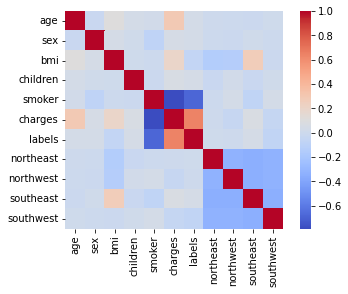

In [284]:
data_new = pd.concat((data_new, Region_dummies), axis=1)
corr_mat = data_new.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
corr_mat.where(np.triu(abs(corr_mat) > 0.5, k=1)).stack().sort_values(ascending=False)

Заметна корреляция между:
1. Ценой страховки и курящими
2. Ценой страховки и принадлежностью к определённому классу

Корреляция для группы 1 группы:

Элементов в классе: 986


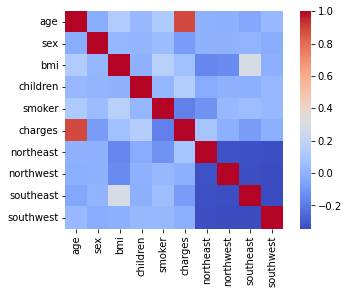

In [285]:
corr_mat = data_new[model.labels_ == 0].drop(['labels'], axis=1).corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
corr_mat.where(np.triu(corr_mat > 0.4, k=1)).stack().sort_values(ascending=False)
print('Элементов в классе: '+str(len(data_new[model.labels_ == 0])))

В кластере 986 элементов

У этой группы основная корреляция цены от возраста

Корреляция для группы 2 группы

Элементов в классе: 156


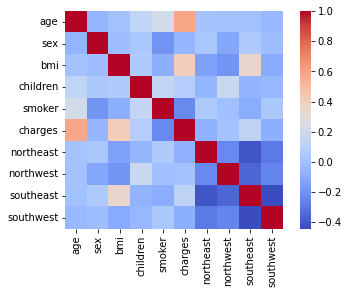

In [286]:
corr_mat = data_new[model.labels_ == 1].drop(['labels'], axis=1).corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
corr_mat.where(np.triu(corr_mat > 0.4, k=1)).stack().sort_values(ascending=False)
print('Элементов в классе: '+str(len(data_new[model.labels_ == 1])))

В кластере 156 элементов

У этой группы корреляция цены от возраста и bmi

Корреляция для группы 3 группы

Элементов в классе: 196


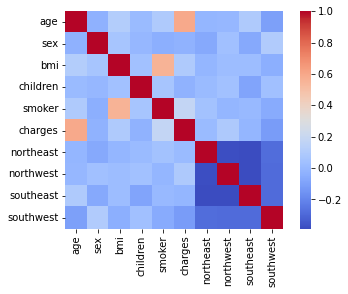

In [287]:
corr_mat = data_new[model.labels_ == 2].drop(['labels'], axis=1).corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
corr_mat.where(np.triu(corr_mat > 0.4, k=1)).stack().sort_values(ascending=False)
print('Элементов в классе: '+str(len(data_new[model.labels_ == 2])))

В кластере 196 элементов

У этой группы корреляция цены от возраста и bmi, и bmi от курения

Видно что корреляция наши предположения по классам верны. Плюс нет заметной корреляции между регионом и другими параметрами, поэтому в дальнейшем их можно убрать из рассмотрения, например когда будем использовать линейную регрессию внутри кластеров. Так же видна несбалансированность полученных кластеров (первый больше 2 и 3).

Теперь у нас есть решающий параметр labels - класс к которому принадлежит объект. Мы можем применить алгоритм классификации k-соседей.

## Создаём классификатор

Разобьём данные на тренировочную и тестовую выборки

In [288]:
X = data_new.drop('labels', axis = 1)
y = data_new['labels']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Пробуем *k*NN 

С 1 соседом

In [289]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [290]:
y_test_predict = knn.predict(X_test)
y_train_predict = knn.predict(X_train)


Посмотрим на ошибку и матрицу путаницы на тренировочной выборке

In [291]:
err_train  = np.mean(y_train  != y_train_predict)
err_train 

0.0

In [292]:
confusion_matrix(y_train, y_train_predict)

array([[683,   0,   0],
       [  0, 109,   0],
       [  0,   0, 144]])

Посмотрим на ошибку и матрицу путаницы на тестовой выборке

In [293]:
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.024875621890547265

In [294]:
confusion_matrix(y_test, y_test_predict)

array([[302,   0,   1],
       [  0,  46,   1],
       [  7,   1,  44]])

Довольно хорошие результаты

Посмотрим какое колличество соседей будет оптимальным

In [295]:
error_rates = []
for i in np.arange(1, 30):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(X_train, y_train)
    new_predictions = new_model.predict(X_test)
    error_rates.append(np.mean(new_predictions != y_test))

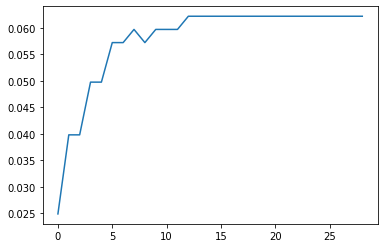

In [296]:
plt.plot(error_rates)

Лучший результат достигается при k=1 

# Logistic

In [297]:
from sklearn.linear_model import LogisticRegression

knn = LogisticRegression()
knn.fit(X_train, y_train)

LogisticRegression()

In [298]:
y_test_predict = knn.predict(X_test)
y_train_predict = knn.predict(X_train)


Посмотрим на ошибку и матрицу путаницы на тренировочной выборке

In [299]:
err_train  = np.mean(y_train  != y_train_predict)
err_train 

0.014957264957264958

In [300]:
confusion_matrix(y_train, y_train_predict)

array([[680,   0,   3],
       [  0, 105,   4],
       [  7,   0, 137]])

Посмотрим на ошибку и матрицу путаницы на тестовой выборке

In [301]:
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.014925373134328358

In [302]:
confusion_matrix(y_test, y_test_predict)

array([[301,   0,   2],
       [  0,  45,   2],
       [  2,   0,  50]])

### Разница работы k-соседей и Logictic на данном датасете не велика, но на тестовой выборке ошибка Logictic всё же лучше.

## Дальше я из интереса я применял линейную регрессию для полученных кластеров

Предсказание цены страховки для человека, по его параметрам и принадлежности к определённому классу

In [303]:
#Убираем регионы
data = data.drop(['northeast'], axis=1)
data = data.drop(['northwest'], axis=1)
data = data.drop(['southeast'], axis=1)
data = data.drop(['southwest'], axis=1)
data = data.drop(['children'], axis=1)

In [304]:
data.head()

,age,sex,bmi,smoker,charges
0,19,0,27.900,0,16884.92400
1,18,1,33.770,1,1725.55230
2,28,1,33.000,1,4449.46200
3,33,1,22.705,1,21984.47061
4,32,1,28.880,1,3866.85520


Предсказываем цену для первого класса

Для этого класса можно было бы оставить зависимоть только цены от возроста, но я решил так не делать и попробовать сделать LR для выех параметров

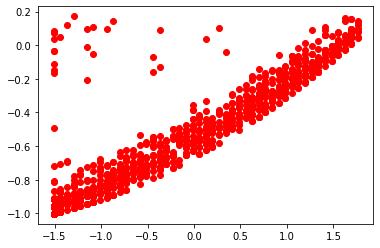

In [305]:
from sklearn.model_selection import train_test_split

data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)

data_lr = pd.concat((data_stand, labels), axis=1)
data_lr = data_lr[data_lr['labels'] == 0]



#X = data_lr.drop(['charges','labels','sex','bmi','smoker'], axis=1)
X = data_lr.drop(['charges','labels'], axis=1)
y = data_lr['charges']


plt.scatter(X['age'],y, color="red")
#Визуализация для проверки правильно ли выбран класс
#Сверху слева НЕ выбросы - это молодые люди с хорошим bmi и логично,
#что их страховка стоит примерно столько же сколько и пожилых но с хорошим bmi

Визуализация для проверки правильно ли выбран класс

Сверху слева НЕ выбросы - это молодые люди с хорошим bmi и логично, что их страховка стоит примерно столько же сколько и пожилых но с хорошим bmi

In [306]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 39)

In [307]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [308]:
y_train_predict = lr_model.predict(X_train)
y_test_predict  = lr_model.predict(X_test)

In [309]:
print(lr_model.coef_)
print(lr_model.intercept_)

[ 0.29513189 -0.01843169 -0.00058984 -0.39098369]
-0.31108219844401525


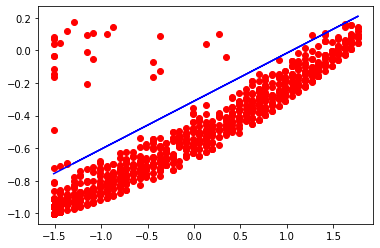

In [310]:
plt.scatter(X['age'],y, color="red")
plt.plot(X['age'],lr_model.coef_[0]*X['age'] + lr_model.intercept_, color='blue' )

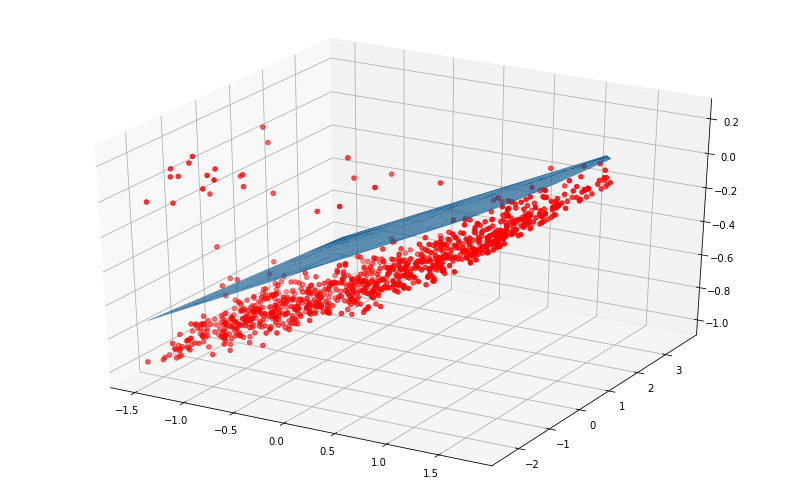

In [311]:
# plt.plot(X['age'],lr_model.coef_[0]*X['age'] + lr_model.intercept_, color='red' )
x_ = np.array(X['age'])
y_ = np.array(X['bmi'])
z_ = np.array(x_*lr_model.coef_[0] + y_*lr_model.coef_[1] + lr_model.intercept_)

 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(X['age'],X['bmi'],y, color='red')
 
# Creating plot
ax.plot_trisurf(x_, y_, z_)